# ECSE 415 Assignment 2, Question 2
### Alex Hale | 260672475 | October 20, 2019

## Matching Using SIFT - Book Reveal

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

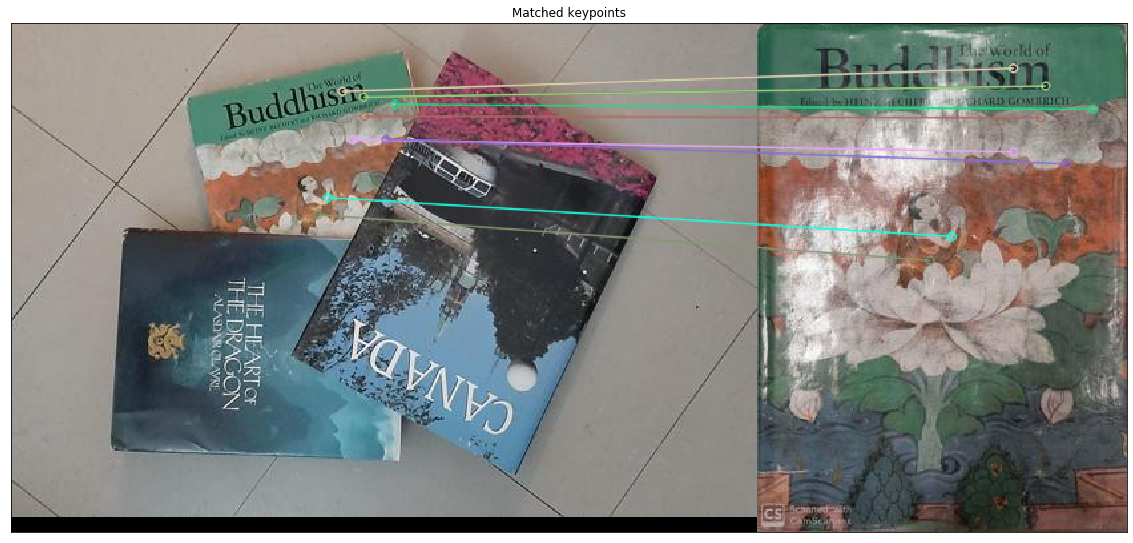

In [2]:
# load images and convert to RGB
book_occ = cv2.imread("book_occlusion.jpg")
book_occ_disp = book_occ.copy()
book_crop = cv2.imread("book_crop.jpg")
book_crop_disp = book_crop.copy()
book_occ = cv2.cvtColor(book_occ, cv2.COLOR_BGR2RGB)
book_crop = cv2.cvtColor(book_crop, cv2.COLOR_BGR2RGB)

# create SIFT and BFMatcher objects
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher()

# detect SIFT features, with a mask on the occluded image and no mask on the cropped image
mask = np.zeros(book_occ.shape[:2], dtype=np.uint8)
cv2.rectangle(mask, (133,20), (310,160), (255), thickness=-1)
keypoints_occ, descriptors_occ = sift.detectAndCompute(book_occ, mask)
keypoints_crop, descriptors_crop = sift.detectAndCompute(book_crop, None)

# find and draw matches
matches = sorted(bf.match(descriptors_occ, descriptors_crop), key = lambda x:x.distance)
match_lines = cv2.drawMatches(book_occ,keypoints_occ,book_crop,keypoints_crop, matches[:10], None, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(match_lines)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

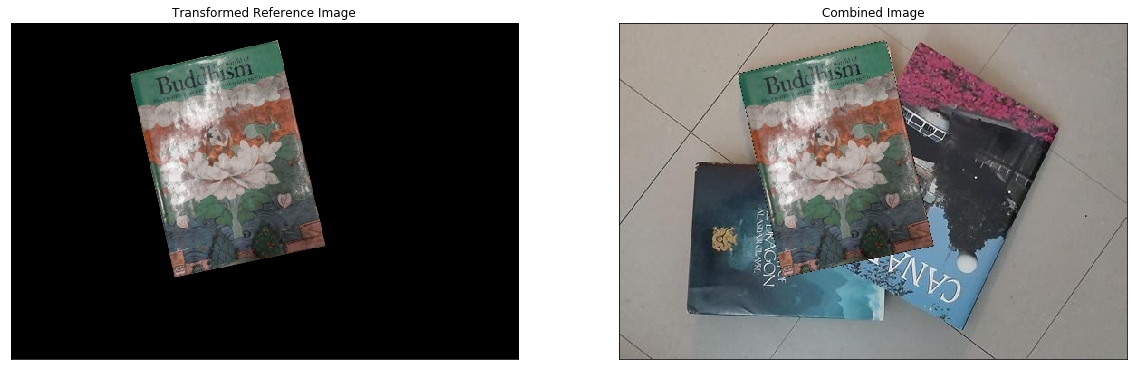

In [3]:
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))
mp_occ = np.float32([keypoints_occ[i].pt for (__, i) in GoodMatches])
mp_crop = np.float32([keypoints_crop[i].pt for (i, __) in GoodMatches])

# find homography and warp image
H, __ = cv2.findHomography(mp_crop, mp_occ, cv2.RANSAC)# 4)
warped_img = cv2.warpPerspective(book_crop, H, (book_crop.shape[1]+book_occ.shape[1], book_crop.shape[0]))

# crop extra black space out of transformed image
warped_img = warped_img[:book_occ.shape[0],:book_occ.shape[1],:]

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(warped_img)
plt.title("Transformed Reference Image"), plt.xticks([]), plt.yticks([])

# should do this with proper array accessing to speed it up
combined_img = book_occ.copy()
for x in range(combined_img.shape[0]):
    for y in range(combined_img.shape[1]):
        for z in range(combined_img.shape[2]):
            if warped_img[x,y,z] > 0:
                combined_img[x,y,z] = warped_img[x,y,z]

plt.subplot(122), plt.imshow(combined_img)
plt.title("Combined Image"), plt.xticks([]), plt.yticks([])
plt.show()